# Рекомендация тарифов

## Описание проекта
Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.
Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.


**Описание данных**  

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:  
•	сalls — количество звонков,  
•	minutes — суммарная длительность звонков в минутах,  
•	messages — количество sms-сообщений,  
•	mb_used — израсходованный интернет-трафик в Мб,  
•	is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).  

## Откройте и изучите файл

**Путь к файлу: /datasets/users_behavior.csv**  

In [1]:
#подключение библиотек, используемых в проекте
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from tqdm import tqdm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('datasets\\users_behavior.csv')

In [3]:
df.info()
display(df.head())
print('Дубликатов в исходных данных: ',df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Дубликатов в исходных данных:  0


Предварительно проанализируем распределение и статистические показатели признаков (calls, minutes, messages, mb_used) объектов в зависимости от значения целевого признака (is_ultra).
Определим вспомогательную функцию для построения гистограмм.

In [4]:
def hist_show(df_ultra, df_smart, col, bins=30):
    ax = df_ultra.plot(kind='hist', histtype = 'step', y=col, color = 'red', alpha = 0.5, bins = bins, figsize=(8,6), linewidth = 2, density=True)
    df_smart.plot(kind='hist', histtype = 'step', y=col, color='green', ax=ax, alpha = 0.5, bins = bins, linewidth = 2, density=True)
    ax.legend(['ULTRA '+col,'SMART '+col])

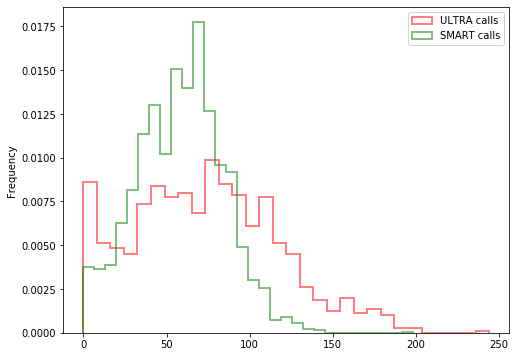

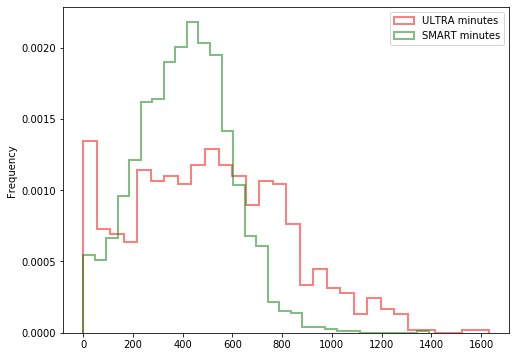

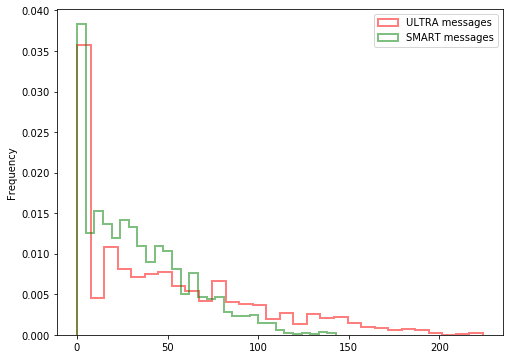

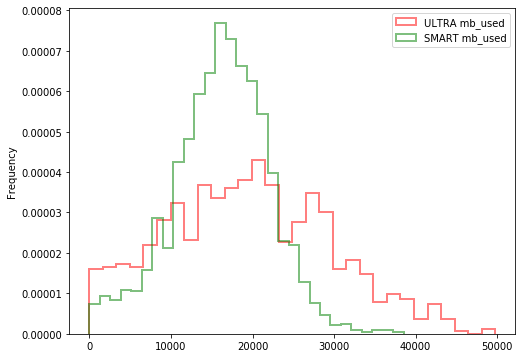

min                             max                              \
         calls mb_used messages minutes  calls   mb_used messages  minutes   
is_ultra                                                                     
0          0.0     0.0      0.0     0.0  198.0  38552.62    143.0  1390.22   
1          0.0     0.0      0.0     0.0  244.0  49745.73    224.0  1632.06   

           mean                            median                             \
          calls   mb_used messages minutes  calls   mb_used messages minutes   
is_ultra                                                                       
0         58.46  16208.47    33.38  405.94   60.0  16506.93     28.0  410.56   
1         73.39  19468.82    49.36  511.22   74.0  19308.01     38.0  502.55   

            std                                 var                         \
          calls   mb_used messages minutes    calls       mb_used messages   
is_ultra                                                                     
0         25.94   5870.50    28.23  184.51   672.88  3.446276e+07   796.81   
1         43.92  10087.18    47.80  308.03  1928.69  1.017512e+08  2285.27   

                    
           minutes  
is_ultra            
0         34044.90  
1         94883.16

Выборка по тарифу ультра содержит  985 объектов, что составляет 30.65 % от общей выборки
Выборка по тарифу смарт содержит  2229 объектов, что составляет 69.35 % от общей выборки


In [5]:
hist_show(df[df['is_ultra']==1], df[df['is_ultra']==0], 'calls')
hist_show(df[df['is_ultra']==1], df[df['is_ultra']==0], 'minutes')
hist_show(df[df['is_ultra']==1], df[df['is_ultra']==0], 'messages')
hist_show(df[df['is_ultra']==1], df[df['is_ultra']==0], 'mb_used')
plt.show()

pvt_stats = df.pivot_table(index='is_ultra', values=['calls','minutes','messages', 'mb_used'], aggfunc=['min','max','mean', 'median', 'std', 'var'])
display(pvt_stats.round(2))
objects_count = df.shape[0]
ultra_count = df[df['is_ultra']==1].shape[0]
smart_count = df[df['is_ultra']==0].shape[0]
print('Выборка по тарифу ультра содержит ', ultra_count, 'объектов, что составляет', round(100*ultra_count/objects_count,2), '% от общей выборки')
print('Выборка по тарифу смарт содержит ', smart_count, 'объектов, что составляет', round(100*smart_count/objects_count,2), '% от общей выборки')

### Выводы

- Данные из файла users_behavior.csv загружены в dataframe с именем df.      
- Набор данных состоит из 5 колонок (4 признака и 1 целевой признак) и 3214 записей (объектов).      
- Дубликаты в исходных данных отсутствуют.  
- Дополнительной обработки данные не требуют.    
- Судя по гистограммам клиенты обоих тарифов пользуются услугами примерно одинаково (формы распределений похожи), исходя из статистических показателей средние и медианные значения по объему оказанных услуг выше у тарифа УЛЬТРА.
- Важно отметить, что у нас наблюдается перекос в выборках, клиентов тарифа СМАРТ значительно больше (более чем в два раза), чем пользователей тарифа УЛЬТРА. В нашем случае, при проверки модели на вменяемость, нужно ориентироваться на показатель Accuracy не в 50% а в 70%. Поскольку если использовать модель, которая будет для любых значений признаков выдавать на выходе тариф "Смарт", то получим значение Accuracy около 70%.

## Разбейте данные на выборки

Исходные данные необходимо разбить на 3 выборки:    
- Обучающую (train)
- Валидационную (valid)    
- Тестовую (test)    
Обучающая выборка используется для обучения модели, валидационная выборка необходима для подбора гиперпараметров модели и позволяет бороться с переобучением. Тестовая выборка используется для проверки качества полученной модели, отобранной на валидационной выборке.    
основное требование к тестовой выборки - она не должна никоим образом использоваться на этапе обучения и валидации модели, иначе полученные результаты будут некорректными.    
Существуют разные подходы к пропорциям разбиения исходных данных: известный популяризатор машинного обучения, профессор Стэнфордского университета Andrew Ng на своих курсах рекомендует пропорцию 70-15-15, на курсе Яндекс.практикум рекомендуют разбиение 60-20-20.   
Воспользуемся в данной работе пропорцией 60-20-20, но добавим возможность задавать требуемое значение по необходимости.    
Для обеспечения повторяемости результатов исследования зададим random_state = 12345

In [6]:
#параметры разбиения выборки
test_size=0.2
rnd_state=12345

Датафрейм без целевого признака запишем в датафрейм features, значение целевого признака в серию target

In [7]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

In [8]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=2*test_size, random_state=rnd_state)

In [9]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=rnd_state)

In [10]:
print('Выполнено разбиение:') 
print('Размер обучающей выборки =', len(target_train))
print('Размер валидационной выборки =', len(target_valid))
print('Размер тестовой выборки =', len(target_test))

Выполнено разбиение:
Размер обучающей выборки = 1928
Размер валидационной выборки = 643
Размер тестовой выборки = 643


### Выводы

- Исходная выборка разбита на обучающую, валидационную и тестовую выборки в пропорции 60-20-20

## Исследуйте модели

В качестве моделей для бинарной классификации используем логистическую регрессию, дерево решений и случайный лес.    
Заранее можно предположить, что случайный лес должен показать лучшие результаты исходя из того что эта модель более сложная и лучше может уловить зависимости в исходных данных - тут главное не переобучить, поэтому будем настраивать гиперпараметры моделей по валидационной выборке.    

### Логистическая регрессия

Предварительно проанализировав работу метода, в качестве настраиваемого гиперпараметра, который может повлиять на accuracy используем solver (метод поиска оптимальных коэффициентов).

In [11]:
best_model = None
best_result = 0
for solver in {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}:
    model = LogisticRegression(random_state=rnd_state, solver=solver, max_iter=5000)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_result:
        best_model = model
        best_result = result

/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


In [12]:
print(best_model)        
print("Accuracy наилучшей модели на валидационной выборке:", best_result.round(2))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)
Accuracy наилучшей модели на валидационной выборке: 0.76


### Дерево решений

В качестве гиперпараметров модели будем использовать:    
- criterion {gini, entropy} - функция для измерения качества разбиения    
- splitter{'best', 'random'} - стратегия разбиения узлов    
- max_depth - максимальная глубина дерева
- min_samples_split - минимальное количество объектов для разбиения узла

In [13]:
best_model = None
best_result = 0

for criterion in {'gini', 'entropy'}:
    for splitter in {'best', 'random'}:
        for max_depth in range(1, 20, 1):
            for min_samples_split in range(2, 10):
                model = DecisionTreeClassifier(random_state=rnd_state, criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_split=min_samples_split)
                model.fit(features_train,target_train)
                result = model.score(features_valid,target_valid)
                if result > best_result:
                    best_model = model
                    best_result = result

print(best_model)        
print("Accuracy наилучшей модели на валидационной выборке:", best_result.round(2))

result_test = model.score(features_test,target_test)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='random')
Accuracy наилучшей модели на валидационной выборке: 0.79


### Случайный лес

В качестве гиперпараметров модели будем использовать:    
- criterion {gini, entropy} - функция для измерения качества разбиения    
- n_estimators - количество деревьев в лесу    
- max_depth - максимальная глубина дерева
- min_samples_split - минимальное количество объектов для разбиения узла

In [14]:
best_model = None
best_result = 0
for max_depth in tqdm(range(1, 15, 1)):
    for n_estimators in range(10, 110, 10):
        for criterion in {'gini', 'entropy'}:
            for min_samples_split in range(2, 5, 1):
                model = RandomForestClassifier(random_state=rnd_state, criterion=criterion, n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
                model.fit(features_train,target_train)
                result = model.score(features_valid,target_valid)
                if result > best_result:
                    best_model = model
                    best_result = result
                    
                    

print(best_model)
print("Accuracy наилучшей модели на валидационной выборке:", best_result.round(2))

100%|██████████| 14/14 [01:53<00:00,  8.07s/it]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)
Accuracy наилучшей модели на валидационной выборке: 0.81


### Выводы

- Исследованы три модели машинного обучения для классификации: логистическая регрессия, дерево решений и случайный лес. Проведена настройка гиперпараметров моделей для подбора параметров с максимальным значением accuracy на валидационной выборке.    
- Наилучшие результату accuracy = 0.81 получены для модели RandomForestClassifier со следующими параметрами:

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)


## Проверьте модель на тестовой выборке

Наилучшие результаты для валидационной выборки получены для модели Случайный лес. Проверим данную модель на тестовой выборке.

In [17]:
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

model.fit(features_train,target_train)

result_valid = accuracy_score(model.predict(features_valid),target_valid)
result_test = accuracy_score(model.predict(features_test),target_test)

print("Accuracy наилучшей модели RandomForestClassifier на валидационной выборке:", result_valid.round(2))
print("Accuracy наилучшей модели RandomForestClassifier на тестовой выборке:", result_test.round(2))

Accuracy наилучшей модели RandomForestClassifier на валидационной выборке: 0.81
Accuracy наилучшей модели RandomForestClassifier на тестовой выборке: 0.8


### Выводы

- На тестовой выборке проверена лучшая модель Случайный лес, показавшая лучшие результаты Accuracy на валидационной выборке:    
Accuracy наилучшей модели RandomForestClassifier на валидационной выборке: 0.81    
Accuracy наилучшей модели RandomForestClassifier на тестовой выборке: 0.8

## (бонус) Проверьте модели на адекватность

Важно отметить, что у нас наблюдается перекос в выборках, клиентов тарифа СМАРТ значительно больше (более чем в два раза), чем пользователей тарифа УЛЬТРА. В нашем случае, при проверки модели на вменяемость, нужно ориентироваться на показатель Accuracy не в 50% а в 70%. Поскольку если использовать модель, которая будет для любых значений признаков выдавать на выходе тариф "Смарт", то получим значение Accuracy около 70%.    
Можно конечно данные цифры не проверять, но поскольку в sklearn есть специально разработанные для этой проверки инструменты - давайте проверим.

In [16]:
for strategy in ('most_frequent', 'stratified', 'uniform'):
    model = DummyClassifier(strategy=strategy, random_state=rnd_state)
    model.fit(features_train,target_train)
    result = model.score(features_test,target_test)
    print('Accuracy модели DummyClassifier с параметром strategy=', strategy,'на тестовой выборке:', result.round(2))

Accuracy модели DummyClassifier с параметром strategy= most_frequent на тестовой выборке: 0.68
Accuracy модели DummyClassifier с параметром strategy= stratified на тестовой выборке: 0.54
Accuracy модели DummyClassifier с параметром strategy= uniform на тестовой выборке: 0.48


Полученные результаты полностью соответствуют предположениям.    
- Для стратегии most_frequent (когда предсказывается всегда тариф смарт, как чаще встречающийся в обучающей выборке) получен результат accuracy=0,68    
- Для стратегии uniform (когда предсказывается результат выбирается случайным образом с вероятностью 50/50) получен результат accuracy=0,48    
- Для стратегии stratified (когда предсказывается результат выбирается случайным образом с вероятностью 30/70 - для нашего случая с учетом распределения целевого признака в обучающей выборке) получен результат accuracy=0,54 - промежуточное значение между двумя предыдущими стратегиями 

Результаты для полученной модели RandomForestClassifier выше чем для модели DummyClassifier, поэтому можно говорить о вменяемости полученной модели

### Выводы

- Результаты для полученной модели RandomForestClassifier выше чем для модели DummyClassifier, поэтому можно сделать вывод, что обученная модель - вменяема

## Общий вывод по проекту

**При выполнении проекта:**

На этапе загрузки и изучения данных:
- Данные из файла users_behavior.csv загружены в dataframe с именем df.      
- Набор данных состоит из 5 колонок (4 признака и 1 целевой признак) и 3214 записей (объектов).      
- Дубликаты в исходных данных отсутствуют.  
- Дополнительной обработки данные не требуют.    
- Судя по гистограммам клиенты обоих тарифов пользуются услугами примерно одинаково (формы распределений похожи), исходя из статистических показателей средние и медианные значения по объему оказанных услуг выше у тарифа УЛЬТРА.
- Важно отметить, что у нас наблюдается перекос в выборках, клиентов тарифа СМАРТ значительно больше (более чем в два раза), чем пользователей тарифа УЛЬТРА. В нашем случае, при проверки модели на вменяемость, нужно ориентироваться на показатель Accuracy не в 50% а в 70%. Поскольку если использовать модель, которая будет для любых значений признаков выдавать на выходе тариф "Смарт", то получим значение Accuracy около 70%.    

На этапе разбиения исходных данных:
- Исходная выборка разбита на обучающую, валидационную и тестовую выборки в пропорции 60-20-20    

На этапе исследования моделей:    
- Исследованы три модели машинного обучения для классификации: логистическая регрессия, дерево решений и случайный лес. Проведена настройка гиперпараметров моделей для подбора параметров с максимальным значением accuracy на валидационной выборке.    
- Наилучшие результату accuracy = 0.82 получены для модели RandomForestClassifier со следующими параметрами:
                       RandomForestClassifier    
                       (bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

На этапе проверки модели на тестовых данных:    
- На тестовой выборке проверена лучшая модель Случайный лес, показавшая лучшие результаты Accuracy на валидационной выборке:    
Accuracy наилучшей модели RandomForestClassifier на валидационной выборке: 0.81    
Accuracy наилучшей модели RandomForestClassifier на тестовой выборке: 0.8

На этапе проверки на вменяемость:
- Проверена вменяемость полученной модели путем сравнения с моделью DummyClassifier.    
- Результаты для полученной модели RandomForestClassifier выше чем для модели DummyClassifier, поэтому можно сделать вывод, что обученная модель - вменяема


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
